#### General Loading + preprocessing
*followed preliminary example here: https://datascience.stackexchange.com/questions/26871/can-someone-spot-anything-wrong-with-my-lstm-forex-model/26876

In [163]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
import yfinance as yf

from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten

import xgboost as xgb

In [3]:
#Loading params
#start_date = '2016-01-01'
start_date = '2008-01-01'
end_date = '2019-08-01'

In [ ]:
#Load correlated data
datacorr = {}

##1 - euro/gbp
datacorr['eurgbp'] = yf.download('EURGBP=X',start_date,end_date)

##2 - FTSE 100
datacorr['ftse'] = yf.download('^FTSE',start_date,end_date)

##3 - VIX (volatility index)
#datacorr['vix'] = yf.download('^VIX',start_date,end_date)

##4 - euro/usd
datacorr['eurusd'] = yf.download('EURUSD=X',start_date,end_date)

##5 - DJI
datacorr['dji'] = yf.download('^DJI',start_date,end_date)

##6 - NASDAQ
datacorr['ixic'] = yf.download('^IXIC',start_date,end_date)

##7 - Nikkei225
datacorr['n225'] = yf.download('^N225',start_date,end_date)

##8 - usd/jpy
#datacorr['usdjpy'] = yf.download('USDJPY=X',start_date,end_date)

##9 - gbp/jpy
datacorr['gbpjpy'] = yf.download('GBPJPY=X',start_date,end_date)

##10 - usd/cny
datacorr['usdcny'] = yf.download('USDCNY=X',start_date,end_date)

##11 - gbp/cny
datacorr['gbpcny'] = yf.download('GBPCNY=X',start_date,end_date)

##12 - TNX (Treasury Yield 10 Years)
datacorr['tnx'] = yf.download('^TNX',start_date,end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [68]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    
    # Create MACD
    #dataset['26ema'] = pd.ewm(dataset['Close'], span=26).mean()
    #dataset['12ema'] = pd.ewm(dataset['price'], span=12).mean()
    #dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    
    # Create Bollinger Bands
    #dataset['20sd'] = pd.stats.moments.rolling_std(dataset['price'],20)
    dataset['20sd'] = dataset['Close'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
    
    #Fourier transform
    close_fft = np.fft.fft(np.asarray(dataset['Close'].tolist()))
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
    fft_list = np.asarray(fft_df['fft'].tolist())
    num_ = 40 #TOGGLE
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    dataset['fft'] = np.abs(np.fft.ifft(fft_list_m10))
    
    #Stacked autoencoders? (future)
    
    
    return dataset

In [179]:
#Get technical indicators on main price

##Load main data
data = yf.download('GBPUSD=X',start_date,end_date)
data = get_technical_indicators(data)

[*********************100%***********************]  1 of 1 completed


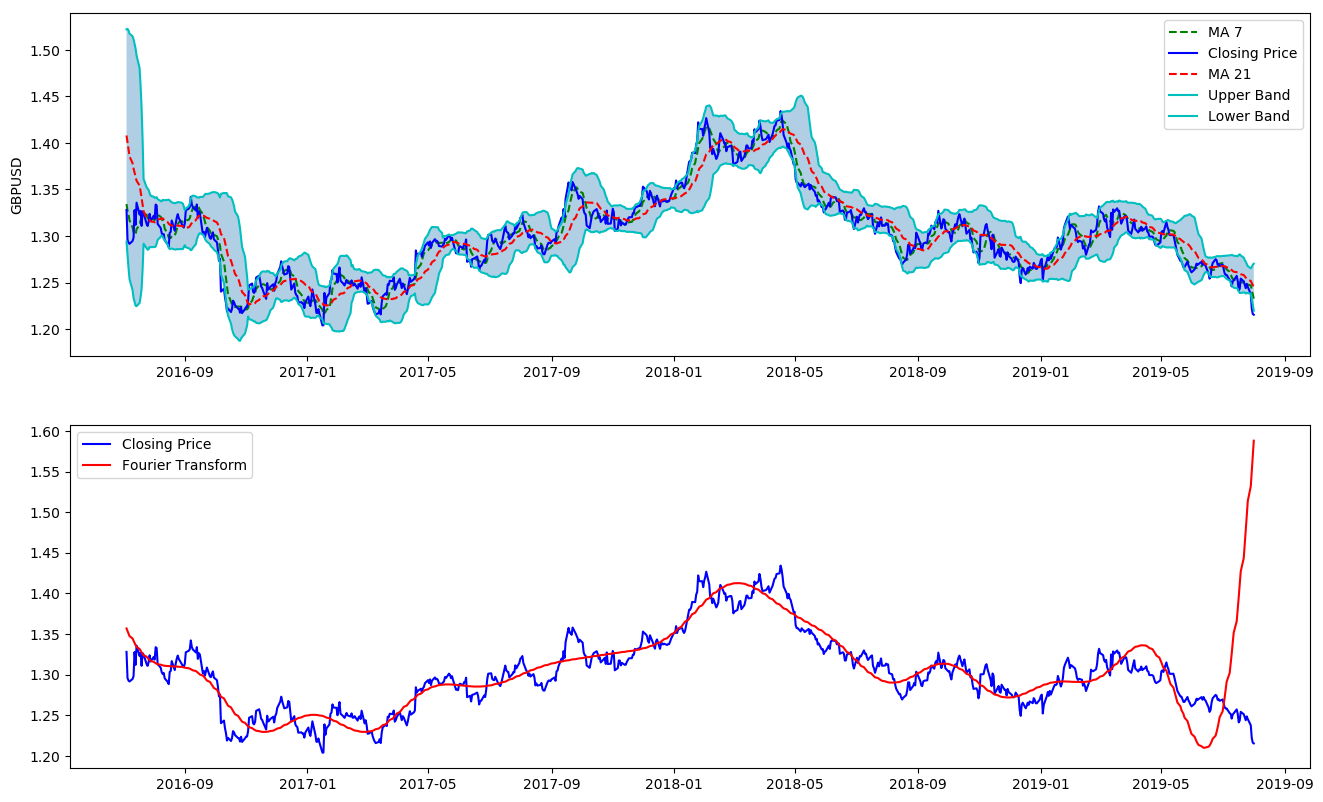

In [87]:
#Visualize technical indicators (for poster)
last_days = 400
last_days = 800

plt.figure(figsize=(16, 10), dpi=100)
shape_0 = data.shape[0]
xmacd_ = shape_0-last_days

data = data.iloc[-last_days:, :]
x_ = range(3, data.shape[0])
x_ =list(data.index)

# Plot first subplot
plt.subplot(2, 1, 1)
plt.plot(data['ma7'],label='MA 7', color='g',linestyle='--')
plt.plot(data['Close'],label='Closing Price', color='b')
plt.plot(data['ma21'],label='MA 21', color='r',linestyle='--')
plt.plot(data['upper_band'],label='Upper Band', color='c')
plt.plot(data['lower_band'],label='Lower Band', color='c')
plt.fill_between(x_, data['lower_band'], data['upper_band'], alpha=0.35)
#plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
plt.ylabel('GBPUSD')
plt.legend()

# Plot second subplot
plt.subplot(2, 1, 2)
plt.plot(data['Close'],label='Closing Price', color='b')
plt.plot(data['fft'],label='Fourier Transform', color='r')

plt.legend()
plt.show()

In [89]:
def scale(X):
    Xmax = max(X)
    Xmin = min(X)
    return (X-Xmin)/(Xmax - Xmin)

In [180]:
#Get other features and concatenate with Closes of other markets

num_features = 4 + len(datacorr.keys()) + 8 + 128 #4 for GBP/USD and 9 other closes and 8 technical indicators

#align dates for all features
for f in datacorr.keys():
    data = data.join(datacorr[f]['Close'],on='Date', how='outer', rsuffix='_'+f).dropna()

#FILTER BY SENTIMENT ANALYSIS (2016 DATE)
with open('src/finDates.p','rb') as f:
    finDates = pickle.load(f)
data = data[data.index.isin(finDates)]
    
x = np.zeros((data.shape[0],num_features))

#store in x
##first 4
datCols = ['Open','Close','High','Low']
for cc,col in enumerate(datCols):
    x[:,cc] = scale(data[col].values)

#next 9
for ff,f in enumerate(datacorr.keys()):
    x[:,ff+cc+1] = scale(data['Close_'+f].values)

#8 technical indicators
datCols = ['ma7','ma21', '20sd', 'upper_band', 'lower_band', 'ema', 'momentum','fft']
for dd,col in enumerate(datCols):
    x[:,dd + ff + cc+2] = scale(data[col].values)

#ADD WORD REPRESENTATIONS
with open('src/word_acts.p','rb') as f:
    word_acts = pickle.load(f)
for ii in range(word_acts.shape[1]):
    x[:,ii + dd + ff + cc+3] = scale(word_acts[:,ii])


In [181]:
print(len(data))
print(x.shape)

1807
(1807, 152)


In [166]:
#get and save dates for other notebook (SHOULD BE FIXED)
myDates = data.reset_index()['Date']
with open('myDates.p','wb') as f:
    pickle.dump(myDates,f)

[16:35:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


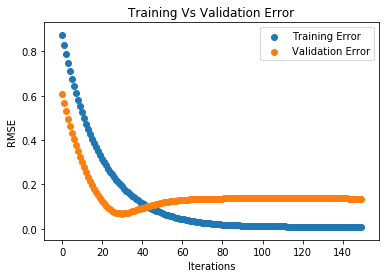

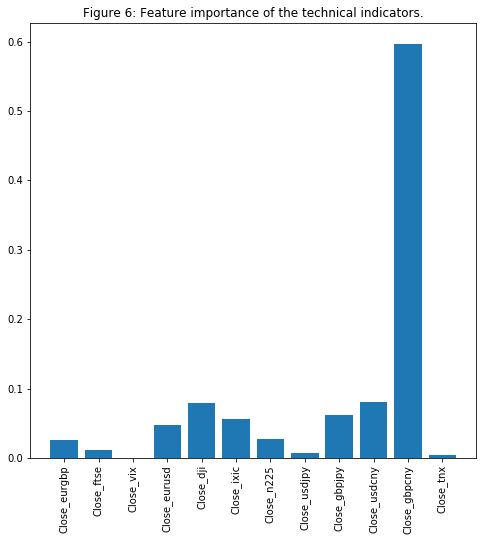

In [137]:
#Get feature importance
def get_feature_importance_data(dataOG,data_income):
    data = data_income.copy()
    y = dataOG['Close']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

dataCopy = data.copy()
del dataCopy['High']
del dataCopy['Low']
del dataCopy['Close']
del dataCopy['Adj Close']
del dataCopy['Volume']

if False:
    for ff,f in enumerate(datacorr.keys()):
        del dataCopy['Close_'+f]
if True:
    for f in ['ma7','ma21', '20sd', 'upper_band', 'lower_band', 'ema', 'momentum','fft']:
        del dataCopy[f]

(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(data,dataCopy)
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

In [185]:
#Get labels
outlook = 1
y_df = data['Close']<data['Close'].shift(-outlook)
y = 1*y_df.values
print(len(y))

1807


In [186]:
#Split data!
train_split = 0.8
train_split = 0.7
total_count = x.shape[0]
train_cut = int(total_count* train_split)

x_train = x[: train_cut-1, :]
x_test = x[train_cut :, :]
y_train = y[: train_cut-1]
y_test = y[train_cut :]

In [190]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 20, 128)           143872    
_________________________________________________________________
lstm_21 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 275,585
Trainable params: 275,585
Non-trainable params: 0
_________________________________________________________________


In [204]:
#Train model!

### Constants
num_time_steps = 30   # Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 20   # Num of steps in batch (also used for prediction steps into the future)
num_features = num_features   # Number of features
num_neurons = 128
num_outputs = 1 # Just one output (True/False), predicted time series
learning_rate = 0.0001 # learning rate, 0.0001 default, but you can play with this
learning_rate = 0.0003 # learning rate, 0.0001 default, but you can play with this
nb_epochs = 14 # how many iterations to go through (training steps), you can play with this
batch_size = 20
batch_size = 100

model = Sequential()
stacked = False
stacked = True
if stacked == True:
    #model.add(LSTM(num_neurons, return_sequences=True, input_shape=(num_time_steps,num_features), activation='relu', dropout=0.3))
    model.add(LSTM(num_neurons, return_sequences=True, input_shape=(num_time_steps,num_features), activation='tanh', dropout=0.5))
    #model.add(LSTM(num_neurons, activation='relu', dropout=0.3))
    model.add(LSTM(num_neurons, activation='tanh', dropout=0.5))
else:
    model.add(LSTM(num_neurons, input_shape=(num_time_steps,num_features), activation='relu', dropout=0.3))

#model.add(Flatten())
model.add(Dense(units=num_outputs, activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

look_back = num_time_steps
x_train_reshape = create_dataset(x_train, look_back=look_back)
y_train_reshape = y_train[(look_back-1):]
x_test_reshape = create_dataset(x_test, look_back=look_back)
y_test_reshape = y_test[(look_back-1):]
history = model.fit(x_train_reshape,
                    y_train_reshape,
                    batch_size = batch_size,
                    epochs = nb_epochs,
                    validation_data=(x_test_reshape, y_test_reshape))

Train on 1244 samples, validate on 524 samples
Epoch 1/14
1244/1244 [==============================] - 2s 2ms/step - loss: 0.7008 - accuracy: 0.5032 - val_loss: 0.6988 - val_accuracy: 0.4580
Epoch 2/14
1244/1244 [==============================] - 1s 834us/step - loss: 0.7039 - accuracy: 0.4904 - val_loss: 0.7046 - val_accuracy: 0.4580
Epoch 3/14
1244/1244 [==============================] - 1s 925us/step - loss: 0.6959 - accuracy: 0.5137 - val_loss: 0.6897 - val_accuracy: 0.5420
Epoch 4/14
1244/1244 [==============================] - 1s 845us/step - loss: 0.7019 - accuracy: 0.4904 - val_loss: 0.6905 - val_accuracy: 0.5420
Epoch 5/14
1244/1244 [==============================] - 1s 838us/step - loss: 0.7028 - accuracy: 0.4984 - val_loss: 0.7035 - val_accuracy: 0.4580
Epoch 6/14
1244/1244 [==============================] - 1s 900us/step - loss: 0.6962 - accuracy: 0.5121 - val_loss: 0.6968 - val_accuracy: 0.4580
Epoch 7/14
1244/1244 [==============================] - 1s 909us/step - loss: 0

In [141]:
def create_dataset(dataset, look_back=1):
    #dataX, dataY = [], []
    dataX= []
    for i in range(len(dataset)-look_back+1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        #dataY.append(dataset[i + look_back - 1, :])
    #return np.array(dataX), np.array(dataY)
    return np.array(dataX)

In [197]:
score, acc = model.evaluate(x_test_reshape, y_test_reshape,
                            batch_size=batch_size)
print("Test accuracy: ", acc)
score, acc = model.evaluate(x_train_reshape, y_train_reshape,
                            batch_size=batch_size)
print("Train accuracy: ", acc)

524/524 [==============================] - 0s 605us/step
Test accuracy:  0.5419847369194031
1244/1244 [==============================] - 1s 586us/step
Train accuracy:  0.5048231482505798


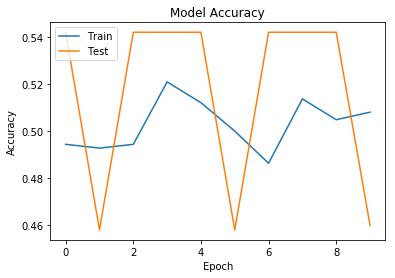

In [202]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

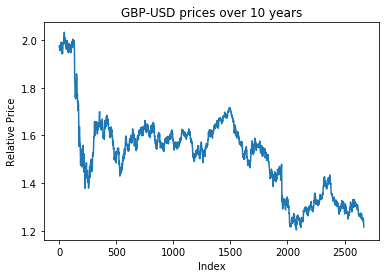

In [164]:
plt.plot(data['Close'].values)
plt.xlabel('Index')
plt.ylabel('Relative Price')
plt.title('GBP-USD prices over 10 years')
plt.show()